Given a black box algorithm, how many passes through the circuit will it take to know if this algorithm is balanced, as in it returns an even number of 1's and 0's) or a constant, as in it always returns all 1's or 0's, assuming we are using 2-bit strings?

Traditionally, a computer would need at least two passes to make a guess at the answer.

A Quantum Computer can make this understanding in one pass, regardless of how many bits we pass through the algorithm...

In [19]:
import qiskit as q
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import math
import matplotlib.pyplot as plt

qasm_sim = q.Aer.get_backend('qasm_simulator')
statevec_sim = q.Aer.get_backend('statevector_simulator')

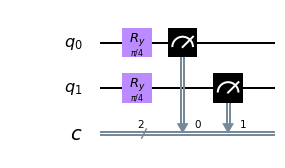

In [4]:
circuit = q.QuantumCircuit(2,2)
circuit.ry(math.pi/4, 0)
circuit.ry(math.pi/4, 1)

orig_statevec = q.execute(circuit, backend=statevec_sim).result()
orig_statevec = orig_statevec.get_statevector()

circuit.measure([0,1], [0,1])
circuit.draw(output='mpl')

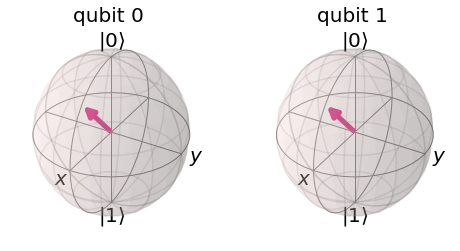

In [5]:
plot_bloch_multivector(orig_statevec)

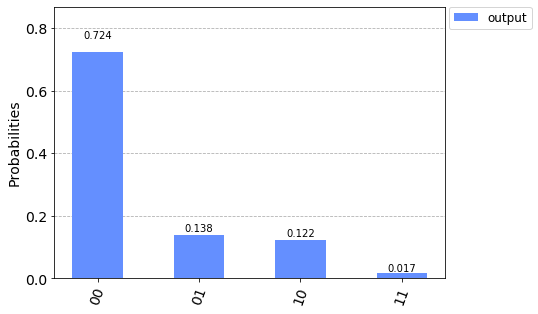

In [6]:
orig_counts = q.execute(circuit, backend=qasm_sim).result().get_counts()
plot_histogram([orig_counts], legend=['output'])

# Adding Hadamard gates

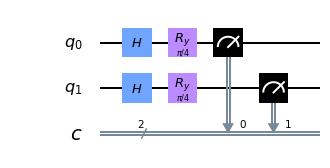

In [7]:
circuit = q.QuantumCircuit(2,2)
circuit.h(0)
circuit.h(1)
circuit.ry(math.pi/4, 0)
circuit.ry(math.pi/4, 1)

statevec = q.execute(circuit, backend=statevec_sim).result()
statevec = statevec.get_statevector()

circuit.measure([0,1], [0,1])
circuit.draw(output='mpl')

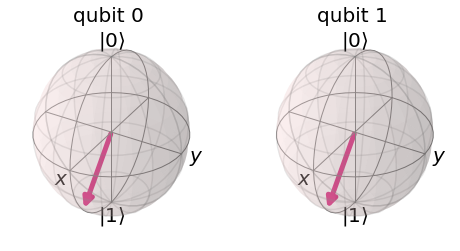

In [8]:
plot_bloch_multivector(statevec)

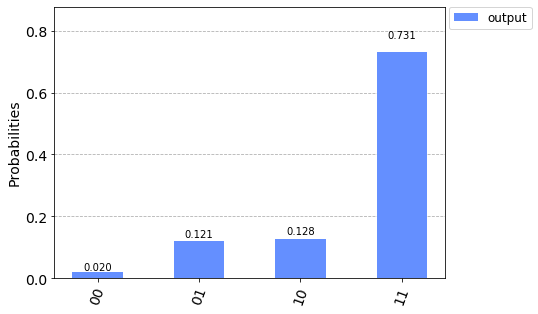

In [9]:
counts = q.execute(circuit, backend=qasm_sim).result().get_counts()
plot_histogram([counts], legend=['output'])

So adding the hadamard gates in front of the rotation gates, thereby superpositioning our qubits, has inverted the probabilities of 00 and 11.

What if we added another set of hadamard gates after our rotations?

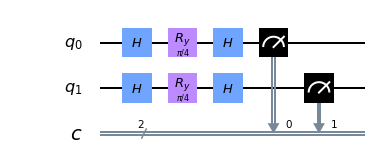

In [10]:
circuit = q.QuantumCircuit(2,2)
circuit.h(0)
circuit.h(1)
circuit.ry(math.pi/4, 0)
circuit.ry(math.pi/4, 1)
circuit.h(0)
circuit.h(1)

statevec = q.execute(circuit, backend=statevec_sim).result()
statevec = statevec.get_statevector()

circuit.measure([0,1], [0,1])
circuit.draw(output='mpl')

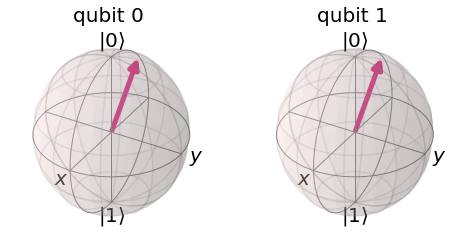

In [11]:
plot_bloch_multivector(statevec)

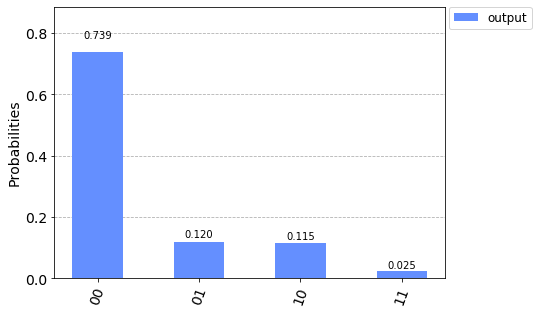

In [12]:
counts = q.execute(circuit, backend=qasm_sim).result().get_counts()
plot_histogram([counts], legend=['output'])

Ok, they inverted counts again! But the vectors are still different.... 

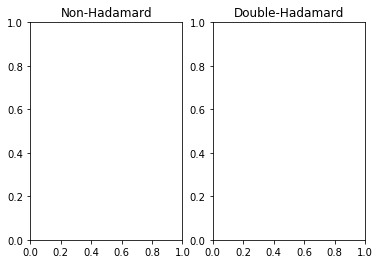

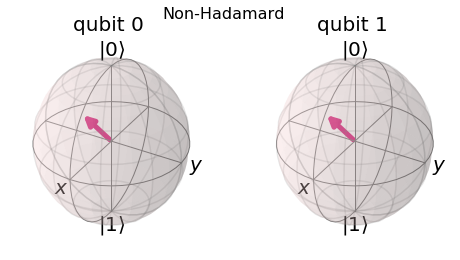

In [34]:
plot_bloch_multivector(orig_statevec, title='Non-Hadamard')

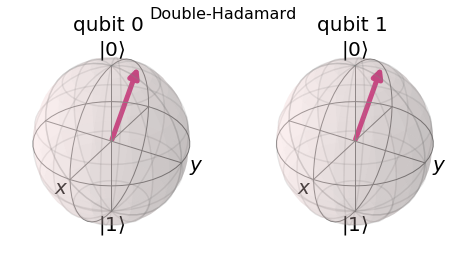

In [35]:
plot_bloch_multivector(statevec, title='Double-Hadamard')

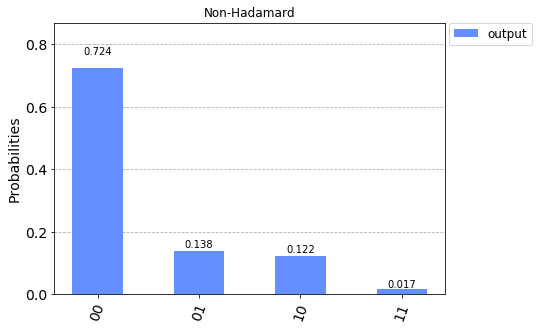

In [36]:
plot_histogram([orig_counts], legend=['output'], title='Non-Hadamard')

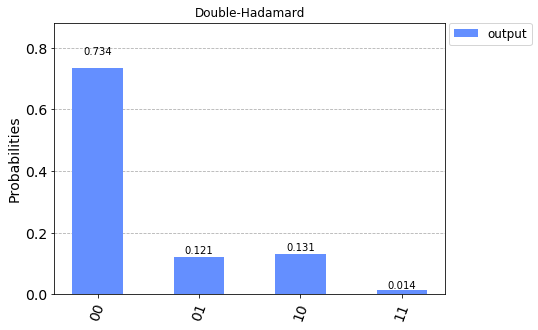

In [37]:
plot_histogram([counts], legend=['output'], title='Double-Hadamard')

So, making the changes with hadamard gates affected the qubits, but not the overall distribution of the measure

Now let's look at Certain Qubits

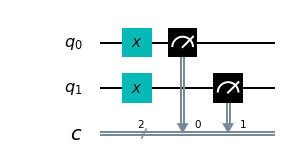

In [51]:
c = q.QuantumCircuit(2,2)
c.x(0)
c.x(1)
orig_statevec = q.execute(c, backend=statevec_sim).result().get_statevector()

c.measure([0,1], [0,1])
orig_counts = q.execute(c, backend=qasm_sim).result().get_counts()
c.draw(output='mpl')

So these certain qubits will always flip to 11. Makes sense, because they initialize to 0, and then we apply a not-gate to each of them, which flips the values and makes each of them 1. So we get 11 in return, 100% of the time.

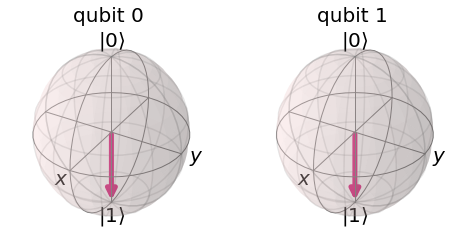

In [52]:
plot_bloch_multivector(orig_statevec)

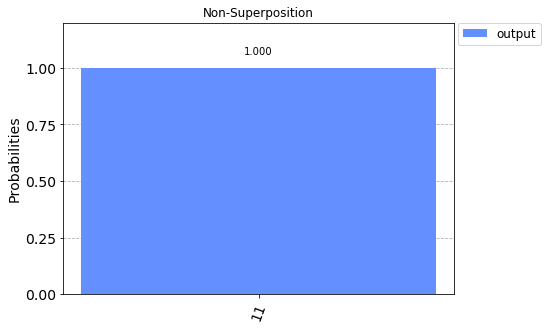

In [53]:
plot_histogram([orig_counts], legend=['output'], title='Non-Superposition')

What happens when we superposition them first?

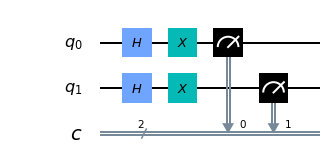

In [54]:
c = q.QuantumCircuit(2,2)
c.h(0)
c.h(1)
c.x(0)
c.x(1)
statevec = q.execute(c, backend=statevec_sim).result().get_statevector()
c.measure([0,1], [0,1])
counts = q.execute(c, backend=qasm_sim).result().get_counts()
c.draw(output='mpl')

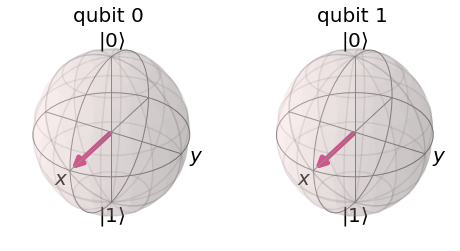

In [55]:
plot_bloch_multivector(statevec)

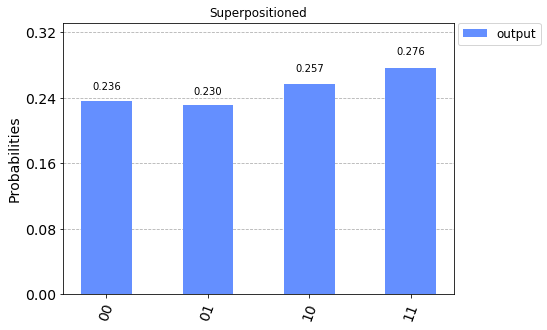

In [56]:
plot_histogram([counts], legend=['output'], title='Superpositioned')

Now it appears that there is an equal chance of all four outcomes happening, now that the qubits are superpositioned prior to applying the not gate. This is because the value of a superpositioned qubit is non-determinant, therefore the flipped value of that same superpositioned qubit is also non-determinant.

But let's try our hadamard-sandwich theory again...

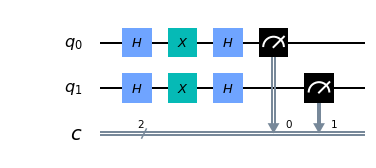

In [57]:
c = q.QuantumCircuit(2,2)
c.h(0)
c.h(1)
c.x(0)
c.x(1)
c.h(0)
c.h(1)
statevec = q.execute(c, backend=statevec_sim).result().get_statevector()
c.measure([0,1], [0,1])
counts = q.execute(c, backend=qasm_sim).result().get_counts()
c.draw(output='mpl')

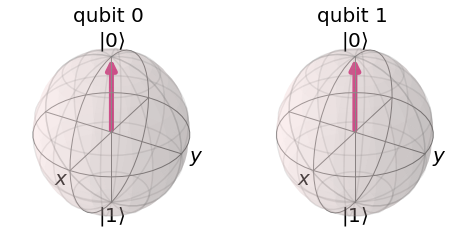

In [58]:
plot_bloch_multivector(statevec)

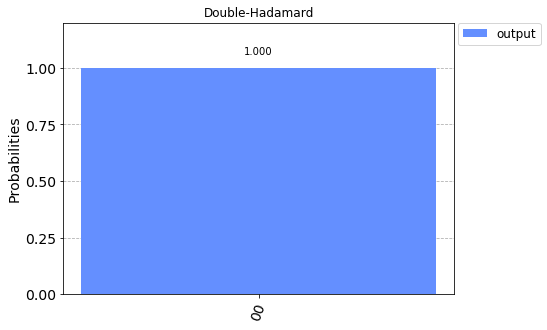

In [49]:
plot_histogram([counts], legend=['output'], title='Double-Hadamard')

Ok, now we have a 100% probability of 00. Which is interesting because previously, when we used the hadamard-sandwhich with uncertain qubits, the distributions remained the same.

But it looks like the flip operations were also undone?

## Black Box Problem

it looks like our constant function can just return the original value, and our balanced function can use cx gates with an entanglement to some 3rd qubit.

In [59]:
def balanced_black_box(circuit):
    circuit.cx(0, 2)
    circuit.cx(1, 2)
    return circuit

def constant_black_box(circuit):
    return circuit

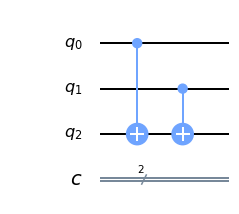

In [60]:
c = q.QuantumCircuit(3, 2)
c = balanced_black_box(c)
c.draw(output='mpl')

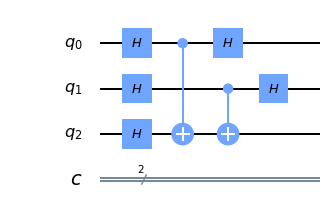

In [61]:
# sandwhich time!

c = q.QuantumCircuit(3, 2)
c.h(0)
c.h(1)
c.h(2)

c = balanced_black_box(c)

c.h(0)
c.h(1)

c.draw(output='mpl')

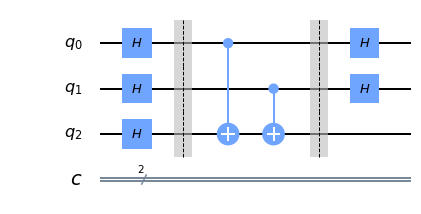

In [62]:
# rewriting using barrier() to make things cleaner

c = q.QuantumCircuit(3, 2)
c.h(0)
c.h(1)
c.h(2)
c.barrier()

c = balanced_black_box(c)
c.barrier()

c.h(0)
c.h(1)

c.draw(output='mpl')

Now we need to add a not-gate before our qubit 2's hadamard gate, but what effect will that have?

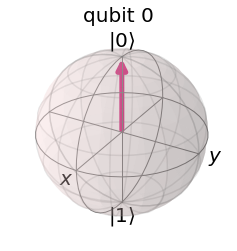

In [79]:
# default circuit
c = q.QuantumCircuit(1,1)

statevec = q.execute(c, backend=statevec_sim).result().get_statevector()
plot_bloch_multivector(statevec)

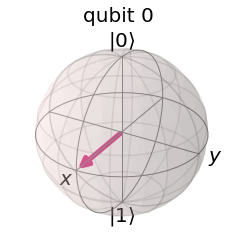

In [89]:
# replicating a hadamard-effect on a vector
c = q.QuantumCircuit(1,1)
c.ry(math.pi/2, 0)
statevec = q.execute(c, backend=statevec_sim).result().get_statevector()
plot_bloch_multivector(statevec)

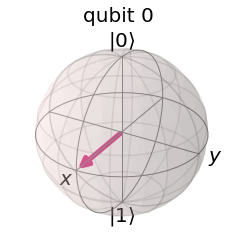

In [76]:
# simple hadamard
c = q.QuantumCircuit(1,1)
c.h(0)
statevec = q.execute(c, backend=statevec_sim).result().get_statevector()
plot_bloch_multivector(statevec)

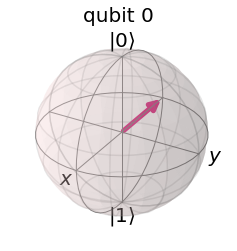

In [74]:
# not, then hadamard
c = q.QuantumCircuit(1,1)
c.x(0)
c.h(0)
statevec = q.execute(c, backend=statevec_sim).result().get_statevector()
plot_bloch_multivector(statevec)

The vector flips on the axis you applied the not gate to?

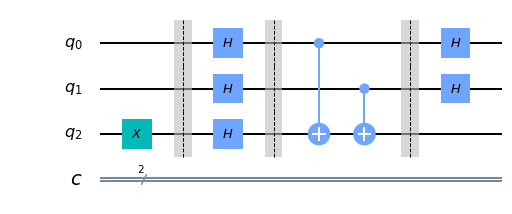

In [65]:
c = q.QuantumCircuit(3,2)

c.x(2)
c.barrier()

c.h(0)
c.h(1)
c.h(2)
c.barrier()
c = balanced_black_box(c)
c.barrier()
c.h(0)
c.h(1)

c.draw(output='mpl')

Ok, that's our circuit, now let's measure it.

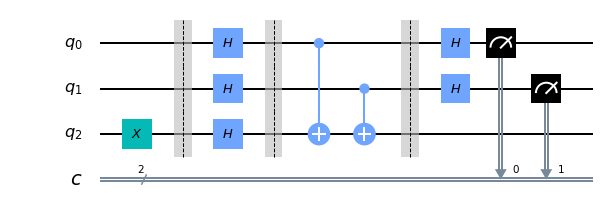

In [82]:
c = q.QuantumCircuit(3,2)
c.x(2)  
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.barrier()
c = balanced_black_box(c)
c.barrier()
c.h(0)
c.h(1)
c.measure([0,1],[0,1])

c.draw(output='mpl')

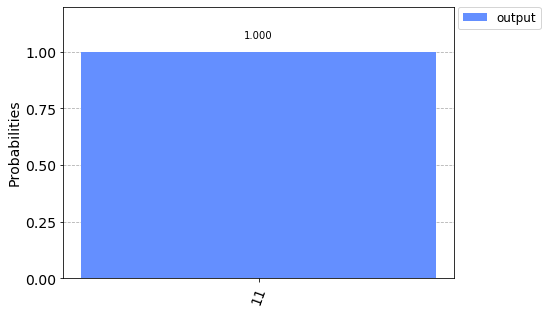

In [83]:
counts = q.execute(c, backend=qasm_sim, shots=1024).result().get_counts()
plot_histogram([counts], legend=['output'])

Ok so the probabilities in this circuit, show us that this circuit will always return 11.

Let's try our constant box.

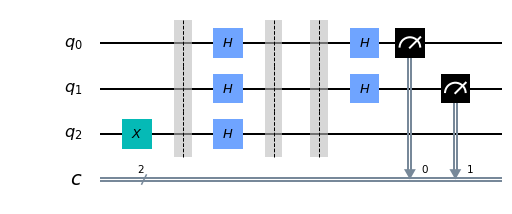

In [86]:
c = q.QuantumCircuit(3,2)
c.x(2)
c.barrier()
c.h(0)
c.h(1)
c.h(2)
c.barrier()
c = constant_black_box(c)  # changed to constant box.
c.barrier()
c.h(0)
c.h(1)
c.measure([0,1],[0,1])
c.draw(output='mpl')

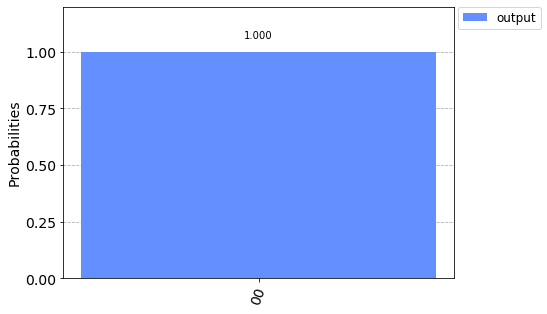

In [87]:
counts = q.execute(c, backend=qasm_sim, shots=1024).result().get_counts()
plot_histogram([counts], legend=['output'])

Ok, our constant box also has a 100% probability of returning 00.